In [ ]:
!mkdir snli_1.0
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip -d snli_1.0

--2023-12-05 18:31:39--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  35.5MB/s    in 2.5s    

2023-12-05 18:31:42 (35.5 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  snli_1.0.zip
   creating: snli_1.0/snli_1.0/
  inflating: snli_1.0/snli_1.0/.DS_Store  
   creating: snli_1.0/__MACOSX/
   creating: snli_1.0/__MACOSX/snli_1.0/
  inflating: snli_1.0/__MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/snli_1.0/Icon  
  inflating: snli_1.0/__MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/snli_1.0/README.txt  
  inflating: snli_1.0/__MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0/snli_1.0_de

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import timeit
!pip install git+https://github.com/davidbau/baukit
from baukit import Trace

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-_436klkl
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-_436klkl
  Resolved https://github.com/davidbau/baukit to commit 5e23007c02fd58f063200c5dc9033e90f092630d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for baukit: filename=baukit-0.0.1-py3-none-any.whl size=59669 sha256=e84ea3db2d03f1ee66584e461f3faf6586979587ab7439f9169c2b9d90c3cb38
  Stored in directory: /tmp/pip-ephem-wheel-cache-3165b807/wheels/e2/7a/dc/eb53bf0e7f86297d7d9759d9eba117036e850e1bfc3bda0176
Successfully built baukit


In [ ]:
dir_path = 'snli_1.0/snli_1.0/'

In [ ]:
train_file_path = dir_path + 'snli_1.0_train.jsonl'
val_file_path = dir_path + 'snli_1.0_dev.jsonl'
test_file_path = dir_path + 'snli_1.0_test.jsonl'

In [ ]:
def read_jsonl(file_path, num_lines=500):
    neutral_lines = num_lines // 3
    entailment_lines = num_lines // 3
    contradiction_lines = num_lines - neutral_lines - entailment_lines

    lines = {'neutral': [], 'entailment': [], 'contradiction': []}
    num_lines = {'neutral': neutral_lines, 'entailment': entailment_lines, 'contradiction': contradiction_lines}
    print(num_lines)

    with open(file_path, 'r') as json_file:
        for line in json_file:
            data = json.loads(line)

            sentence1 = data['sentence1']
            sentence2 = data['sentence2']
            label = data['gold_label']

            if label not in lines.keys():
                continue

            if len(lines[label]) < num_lines[label]:
                lines[label].append((sentence1, sentence2))

            all_done = True
            for key in lines.keys():
                if len(lines[key]) != num_lines[key]:
                    all_done = False
            if all_done:
                return lines

    return lines

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
gpt_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
def transformed_data(lines):
    training_data = []
    sent2_training_data = []
    for key in lines.keys():
        for sentence1, sentence2 in lines[key]:
            transformed_sent = sentence1 + ' This has the same meaning as: ' + sentence2
            training_data.append(transformed_sent)
            sent2_training_data.append(sentence2)
    return training_data, sent2_training_data

def get_representation(model, layer_name, inp, sent2_inp):
    with Trace(model, layer_name) as ret:
        _ = model(inp)
        representation = ret.output
        assert(representation.shape[1] == inp.shape[0])
        num_tokens_to_take = inp.shape[0] - sent2_inp.shape[0]
        representation = representation[:, num_tokens_to_take:, :].detach().clone()
        return representation

def get_all_hidden_states(layer_name, training_data, sent2_training_data):
    hidden_states = []
    for i in range(len(training_data)):
        hidden_states.append(get_representation(gpt_model, layer_name, torch.tensor(tokenizer.encode(training_data[i])), torch.tensor(tokenizer.encode(sent2_training_data[i]))))
    return hidden_states

In [ ]:
lines = read_jsonl(train_file_path)
for key in lines.keys():
    print(key, len(lines[key]))

{'neutral': 166, 'entailment': 166, 'contradiction': 168}
neutral 166
entailment 166
contradiction 168


In [ ]:
training_data, sent2_training_data = transformed_data(lines)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hidden_states_1 = get_all_hidden_states('transformer.h.0.mlp', training_data, sent2_training_data)
with open('/content/drive/MyDrive/hidden_states_1.pkl', 'wb') as f:
    pickle.dump(hidden_states_1, f)
with open('/content/drive/MyDrive/hidden_states_1.pkl', 'rb') as f:
    hidden_states_1 = pickle.load(f)

In [ ]:
print(len(hidden_states_1))
print(hidden_states_1[0].shape)

500
torch.Size([1, 10, 768])


In [ ]:
hidden_states_6 = get_all_hidden_states('transformer.h.5.mlp', training_data, sent2_training_data)
with open('/content/drive/MyDrive/hidden_states_6.pkl', 'wb') as f:
    pickle.dump(hidden_states_6, f)
with open('/content/drive/MyDrive/hidden_states_6.pkl', 'rb') as f:
    hidden_states_6 = pickle.load(f)

In [ ]:
print(len(hidden_states_6))
print(hidden_states_6[0].shape)

500
torch.Size([1, 10, 768])


In [ ]:
hidden_states_12 = get_all_hidden_states('transformer.h.11.mlp', training_data, sent2_training_data)
with open('/content/drive/MyDrive/hidden_states_12.pkl', 'wb') as f:
    pickle.dump(hidden_states_12, f)
with open('/content/drive/MyDrive/hidden_states_12.pkl', 'rb') as f:
    hidden_states_12 = pickle.load(f)

In [ ]:
print(len(hidden_states_12))
print(hidden_states_12[0].shape)

500
torch.Size([1, 10, 768])


In [ ]:
train_lines = read_jsonl(train_file_path)
val_lines = read_jsonl(val_file_path, num_lines=100)
test_lines = read_jsonl(test_file_path, num_lines=100)

{'neutral': 166, 'entailment': 166, 'contradiction': 168}
{'neutral': 33, 'entailment': 33, 'contradiction': 34}
{'neutral': 33, 'entailment': 33, 'contradiction': 34}


In [ ]:
with open('/content/drive/MyDrive/hidden_states_1.pkl', 'rb') as f:
    train_hidden_states = pickle.load(f)

In [ ]:
val_data, sent2_val_data = transformed_data(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.0.mlp', val_data, sent2_val_data)

In [ ]:
test_data, sent2_test_data = transformed_data(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.0.mlp', test_data, sent2_test_data)

In [ ]:
print(len(train_hidden_states), len(val_hidden_states), len(test_hidden_states))
print(train_hidden_states[0].shape, val_hidden_states[0].shape, test_hidden_states[0].shape)

500 100 100
torch.Size([1, 10, 768]) torch.Size([1, 15, 768]) torch.Size([1, 8, 768])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states):
    all_hidden_states = train_hidden_states + val_hidden_states + test_hidden_states
    all_hidden_states = [t.squeeze(0) for t in all_hidden_states]
    padded_sequences = pad_sequence(all_hidden_states, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences.to(device)
    train_hidden_states_tensor = padded_sequences[:len(train_hidden_states)]
    val_hidden_states_tensor = padded_sequences[len(train_hidden_states):len(train_hidden_states) + len(val_hidden_states)]
    test_hidden_states_tensor = padded_sequences[len(train_hidden_states) + len(val_hidden_states):]
    return train_hidden_states_tensor.detach().clone(), val_hidden_states_tensor.detach().clone(), test_hidden_states_tensor.detach().clone()

In [ ]:
label_2_idx = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
idx_2_label = {0: 'neutral', 1: 'entailment', 2: 'contradiction'}

In [ ]:
def get_labels(train_lines, val_lines, test_lines):
    train_labels = []
    val_labels = []
    test_labels = []
    for key in train_lines.keys():
        train_labels += [label_2_idx[key]] * len(train_lines[key])
    for key in val_lines.keys():
        val_labels += [label_2_idx[key]] * len(val_lines[key])
    for key in test_lines.keys():
        test_labels += [label_2_idx[key]] * len(test_lines[key])
    return torch.tensor(train_labels, device=device).detach().clone(), torch.tensor(val_labels, device=device).detach().clone(), torch.tensor(test_labels, device=device).detach().clone()

In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([500, 26, 768]) torch.Size([100, 26, 768]) torch.Size([100, 26, 768])
torch.Size([500]) torch.Size([100]) torch.Size([100])


In [ ]:
class Data_X_y(torch.utils.data.IterableDataset):
    def __init__(self, X, y):
        super(Data_X_y, self).__init__()
        self.X = X
        self.y = y
    def __iter__(self):
        for x, y in zip(self.X, self.y):
            yield(x, y)

In [ ]:
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
inp_dims = 0
for batch in train_dataloader:
    data, labels = batch
    inp_dims = (data.shape[1] * data.shape[2])
    print(inp_dims)
    print(data.device, labels.device)
    print(data.dtype, labels.dtype)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    break

19968
cuda:0 cuda:0
torch.float32 torch.int64
Data shape: torch.Size([25, 26, 768])
Labels shape: torch.Size([25])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, inp_dims):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inp_dims, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probabilities = self.softmax(logits)
        return probabilities

In [ ]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for (x,y) in dataloader:

        (x, y) = ( x.to(device), y.to(device) )

        output = model(x)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, y)

        if train_flag:
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean((output.argmax(axis=1) == y).float())
        accuracies.append(accuracy.detach().cpu().numpy())

    return (np.mean(losses), np.mean(accuracies))

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, patience=10, epochs = 1000, check_point_filename='checkpoint.pt'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses = []
    val_losses = []
    patience = patience # for early stopping
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = check_point_filename # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, val_dataloader, model, optimizer, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" %
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))
    return model, train_losses, val_losses

In [ ]:
model = NeuralNetwork(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.24s. Train loss: 1.0986 acc: 0.3380. Val loss: 1.0984 acc: 0.3600. Patience left: 10
Epoch 2 took 0.40s. Train loss: 1.0985 acc: 0.3440. Val loss: 1.0984 acc: 0.3600. Patience left: 10
Epoch 3 took 0.34s. Train loss: 1.0984 acc: 0.3500. Val loss: 1.0984 acc: 0.3500. Patience left: 10
Epoch 4 took 0.33s. Train loss: 1.0983 acc: 0.3540. Val loss: 1.0983 acc: 0.3500. Patience left: 10
Epoch 5 took 0.37s. Train loss: 1.0981 acc: 0.3560. Val loss: 1.0983 acc: 0.3500. Patience left: 10
Epoch 6 took 0.37s. Train loss: 1.0980 acc: 0.3640. Val loss: 1.0983 acc: 0.3500. Patience left: 10
Epoch 7 took 0.34s. Train loss: 1.0979 acc: 0.3700. Val loss: 1.0983 acc: 0.3500. Patience left: 10
Epoch 8 took 0.35s. Train loss: 1.0978 acc: 0.3840. Val loss: 1.0982 acc: 0.3500. Patience left: 10
Epoch 9 took 0.34s. Train loss: 1.0977 acc: 0.3840. Val loss: 1.0982 acc: 0.3500. Patience left: 10
Epoch 10 took 0.38s. Train loss: 1.0976 acc: 0.3940. Val loss: 1.0982 acc: 0.3500. Patience left: 10

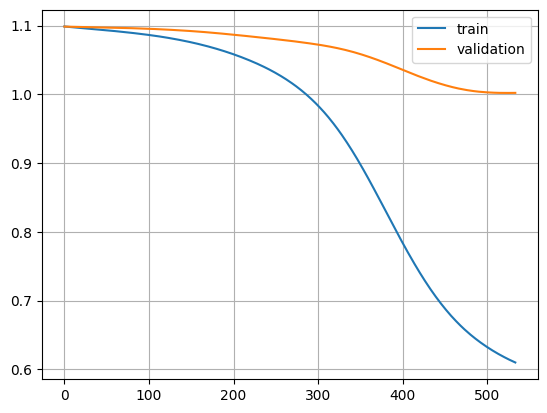

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.grid(which="both")

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.54

In [ ]:
class NeuralNetworkDropout(nn.Module):
    def __init__(self, inp_dims, dropout_prob=0.2):
        super(NeuralNetworkDropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inp_dims, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probabilities = self.softmax(logits)
        return probabilities

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.23s. Train loss: 1.0994 acc: 0.3300. Val loss: 1.0988 acc: 0.3400. Patience left: 10
Epoch 2 took 0.32s. Train loss: 1.0988 acc: 0.3440. Val loss: 1.0988 acc: 0.3400. Patience left: 10
Epoch 3 took 0.30s. Train loss: 1.0991 acc: 0.3200. Val loss: 1.0987 acc: 0.3400. Patience left: 10
Epoch 4 took 0.39s. Train loss: 1.0988 acc: 0.3400. Val loss: 1.0987 acc: 0.3400. Patience left: 10
Epoch 5 took 0.29s. Train loss: 1.0990 acc: 0.3140. Val loss: 1.0987 acc: 0.3400. Patience left: 10
Epoch 6 took 0.52s. Train loss: 1.0987 acc: 0.3400. Val loss: 1.0987 acc: 0.3400. Patience left: 10
Epoch 7 took 0.29s. Train loss: 1.0989 acc: 0.3260. Val loss: 1.0986 acc: 0.3400. Patience left: 10
Epoch 8 took 0.71s. Train loss: 1.0987 acc: 0.3400. Val loss: 1.0986 acc: 0.3300. Patience left: 10
Epoch 9 took 0.39s. Train loss: 1.0985 acc: 0.3580. Val loss: 1.0986 acc: 0.3200. Patience left: 10
Epoch 10 took 0.39s. Train loss: 1.0980 acc: 0.3800. Val loss: 1.0986 acc: 0.3200. Patience left: 10

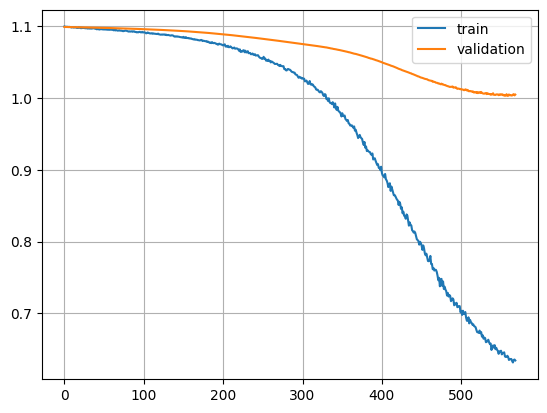

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.grid(which="both")

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.56

In [ ]:
# Why not try a basic NN without activation :) [Bengio et al.]
class NeuralNetwork_No_ReLU(nn.Module):
    def __init__(self, inp_dims):
        super(NeuralNetwork_No_ReLU, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inp_dims, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.Dropout(0.2),
            nn.Linear(512, 3)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probabilities = self.softmax(logits)
        return probabilities

In [ ]:
model = NeuralNetwork_No_ReLU(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.23s. Train loss: 1.1033 acc: 0.2880. Val loss: 1.0988 acc: 0.3700. Patience left: 10
Epoch 2 took 0.28s. Train loss: 1.1003 acc: 0.3120. Val loss: 1.0981 acc: 0.3900. Patience left: 10
Epoch 3 took 5.16s. Train loss: 1.0993 acc: 0.3120. Val loss: 1.0976 acc: 0.4000. Patience left: 10
Epoch 4 took 0.26s. Train loss: 1.0986 acc: 0.3320. Val loss: 1.0970 acc: 0.4000. Patience left: 10
Epoch 5 took 0.30s. Train loss: 1.0970 acc: 0.3520. Val loss: 1.0964 acc: 0.4200. Patience left: 10
Epoch 6 took 0.31s. Train loss: 1.0947 acc: 0.3460. Val loss: 1.0959 acc: 0.4000. Patience left: 10
Epoch 7 took 0.33s. Train loss: 1.0966 acc: 0.3660. Val loss: 1.0954 acc: 0.3700. Patience left: 10
Epoch 8 took 0.35s. Train loss: 1.0926 acc: 0.4180. Val loss: 1.0949 acc: 0.3800. Patience left: 10
Epoch 9 took 0.35s. Train loss: 1.0923 acc: 0.4140. Val loss: 1.0944 acc: 0.3800. Patience left: 10
Epoch 10 took 0.38s. Train loss: 1.0905 acc: 0.3760. Val loss: 1.0939 acc: 0.3700. Patience left: 10

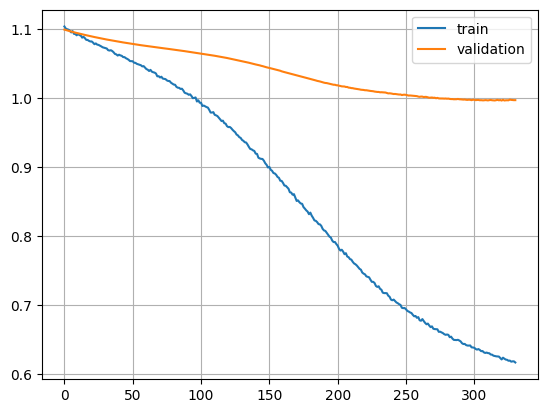

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.grid(which="both")

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.53

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.35s. Train loss: 1.1071 acc: 0.1820. Val loss: 1.0991 acc: 0.3400. Patience left: 10
Epoch 2 took 0.41s. Train loss: 1.0972 acc: 0.3420. Val loss: 1.0985 acc: 0.3200. Patience left: 10
Epoch 3 took 0.41s. Train loss: 1.0945 acc: 0.3700. Val loss: 1.0977 acc: 0.3600. Patience left: 10
Epoch 4 took 0.39s. Train loss: 1.0913 acc: 0.4120. Val loss: 1.0969 acc: 0.3600. Patience left: 10
Epoch 5 took 0.38s. Train loss: 1.0881 acc: 0.4380. Val loss: 1.0959 acc: 0.4000. Patience left: 10
Epoch 6 took 0.44s. Train loss: 1.0847 acc: 0.4740. Val loss: 1.0949 acc: 0.4000. Patience left: 10
Epoch 7 took 0.93s. Train loss: 1.0805 acc: 0.4900. Val loss: 1.0937 acc: 0.4000. Patience left: 10
Epoch 8 took 0.47s. Train loss: 1.0757 acc: 0.5100. Val loss: 1.0923 acc: 0.4100. Patience left: 10
Epoch 9 took 0.50s. Train loss: 1.0688 acc: 0.5340. Val loss: 1.0905 acc: 0.4000. Patience left: 10
Epoch 10 took 0.48s. Train loss: 1.0618 acc: 0.5820. Val loss: 1.0882 acc: 0.4000. Patience left: 10

In [ ]:
def plot_train_validation(train_losses, val_losses):
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.grid(which="both")

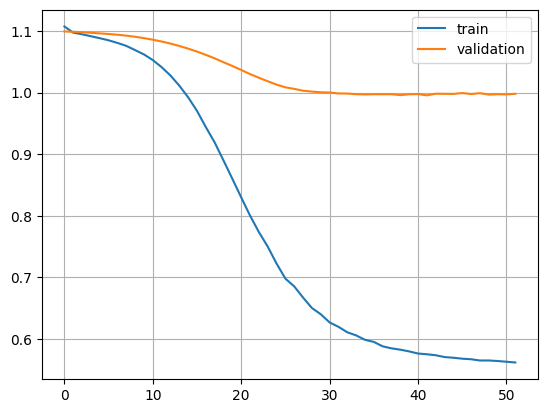

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.53

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.66s. Train loss: 1.2519 acc: 0.2940. Val loss: 1.2214 acc: 0.3300. Patience left: 10
Epoch 2 took 0.26s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 9
Epoch 3 took 0.28s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 8
Epoch 4 took 0.76s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 7
Epoch 5 took 0.27s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 6
Epoch 6 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 5
Epoch 7 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 4
Epoch 8 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 3
Epoch 9 took 0.20s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 2
Epoch 10 took 0.47s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 1


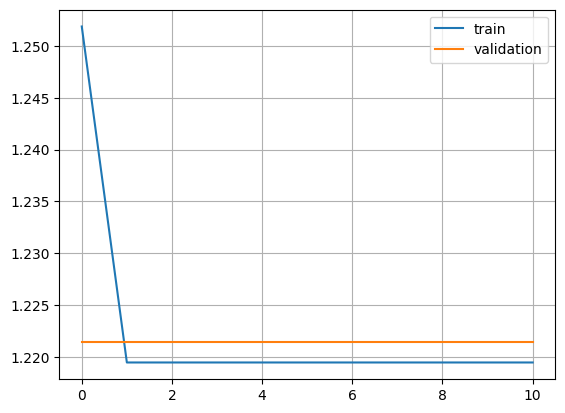

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.32999998

In [ ]:
train_losses_vec, val_losses_vec, test_accs_vec = [], [], []
for i in range(1, 7 + 1):
    lr = 10 ** (-i)
    model = NeuralNetworkDropout(inp_dims=inp_dims).to(device) # using the dropout version
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print("Training Adam with learning rate = %s" %lr)
    model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, check_point_filename="checkpoint_" + str(i))
    train_losses_vec.append(train_losses)
    val_losses_vec.append(val_losses)
    test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
    test_accs_vec.append(test_acc)

Training Adam with learning rate = 0.1
Epoch 1 took 0.35s. Train loss: 1.2470 acc: 0.2840. Val loss: 1.2214 acc: 0.3300. Patience left: 10
Epoch 2 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 9
Epoch 3 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 8
Epoch 4 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 7
Epoch 5 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 6
Epoch 6 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 5
Epoch 7 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 4
Epoch 8 took 0.18s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 3
Epoch 9 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214 acc: 0.3300. Patience left: 2
Epoch 10 took 0.19s. Train loss: 1.2194 acc: 0.3320. Val loss: 1.2214

In [ ]:
test_accs_vec

[0.32999998,
 0.32999998,
 0.32999998,
 0.46999997,
 0.53999996,
 0.53999996,
 0.46999997]

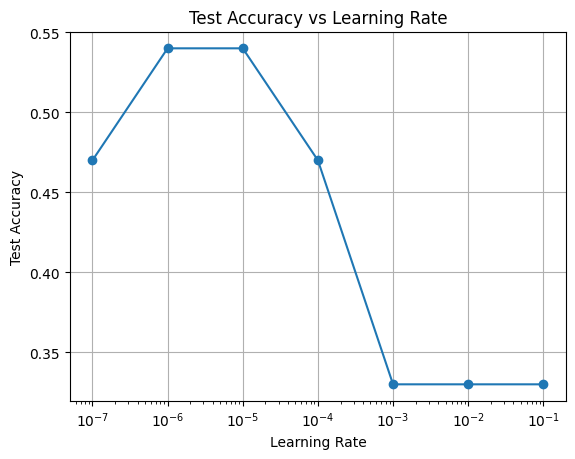

In [ ]:
plt.plot([10**(-i) for i in range(1, 7 + 1)], test_accs_vec, marker='o')
plt.xscale('log')  # Use log scale for better visualization if learning rates are on a wide scale
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

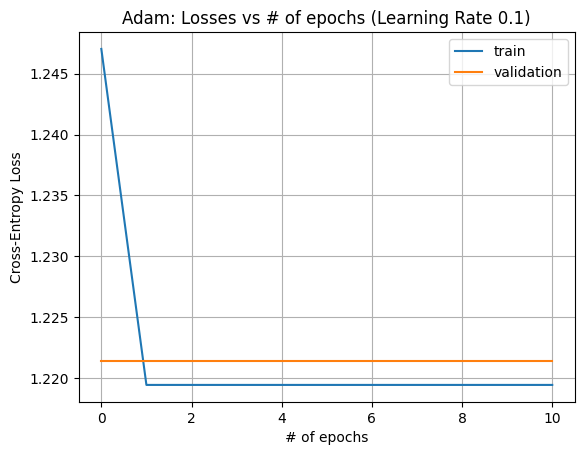

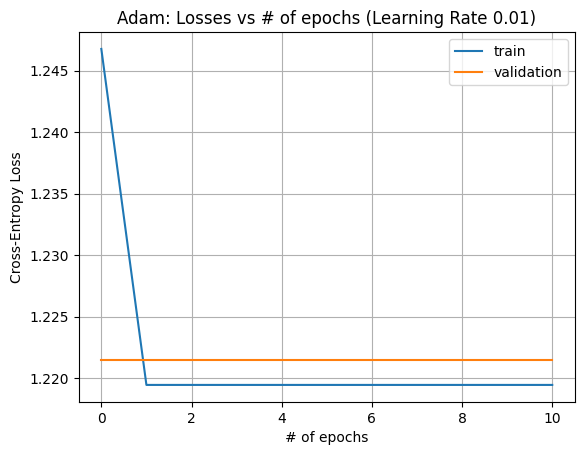

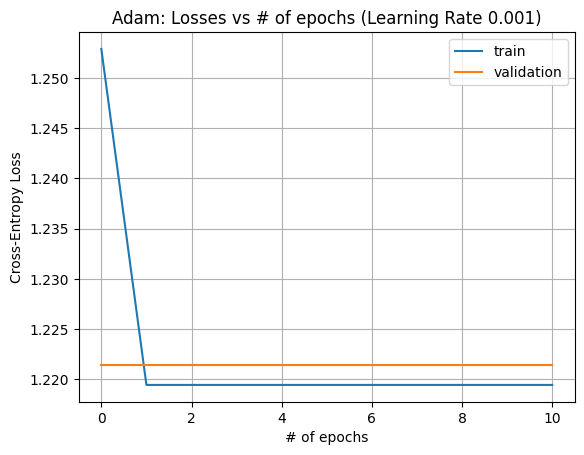

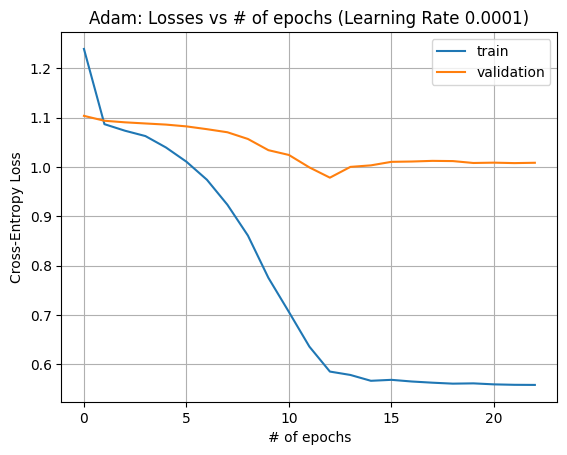

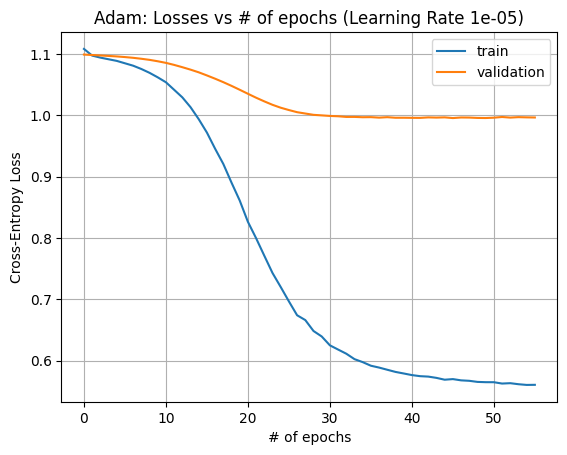

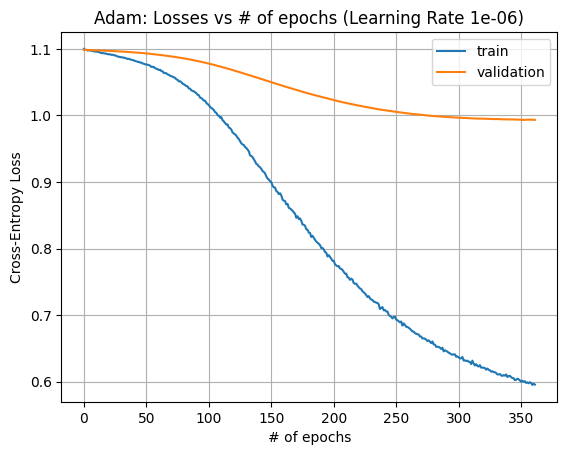

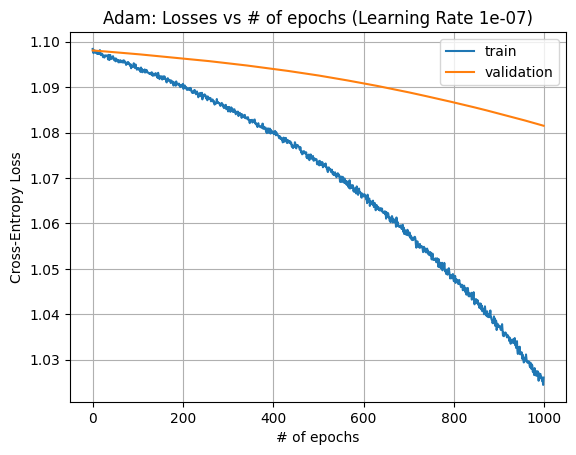

In [ ]:
for i in range(len(train_losses_vec)):
    plt.figure()  # Create a new figure for each index
    plt.xlabel('# of epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'Adam: Losses vs # of epochs (Learning Rate {10**(-(i+1))})')
    plt.plot(train_losses_vec[i], label="train")
    plt.plot(val_losses_vec[i], label="validation")
    plt.legend()
    plt.grid(which="both")
    plt.show()

In [ ]:
train_losses_vec, val_losses_vec, test_accs_vec = [], [], []
for i in range(1, 7 + 1):
    lr = 10 ** (-i)
    model = NeuralNetworkDropout(inp_dims=inp_dims).to(device) # using the dropout version
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    print("Training SGD with learning rate = %s" %lr)
    model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, check_point_filename="checkpoint_" + str(i))
    train_losses_vec.append(train_losses)
    val_losses_vec.append(val_losses)
    test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
    test_accs_vec.append(test_acc)

Training SGD with learning rate = 0.1
Epoch 1 took 0.35s. Train loss: 1.1053 acc: 0.4500. Val loss: 1.1008 acc: 0.3400. Patience left: 10
Epoch 2 took 0.10s. Train loss: 1.1069 acc: 0.3800. Val loss: 1.1044 acc: 0.3400. Patience left: 9
Epoch 3 took 0.09s. Train loss: 1.1081 acc: 0.3420. Val loss: 1.1072 acc: 0.3400. Patience left: 8
Epoch 4 took 0.09s. Train loss: 1.1108 acc: 0.3160. Val loss: 1.1023 acc: 0.3400. Patience left: 7
Epoch 5 took 0.35s. Train loss: 1.1096 acc: 0.3100. Val loss: 1.0997 acc: 0.3400. Patience left: 10
Epoch 6 took 1.80s. Train loss: 1.1037 acc: 0.3260. Val loss: 1.0993 acc: 0.3400. Patience left: 10
Epoch 7 took 0.42s. Train loss: 1.1047 acc: 0.3060. Val loss: 1.0986 acc: 0.3400. Patience left: 10
Epoch 8 took 0.11s. Train loss: 1.1026 acc: 0.3200. Val loss: 1.0989 acc: 0.3400. Patience left: 9
Epoch 9 took 0.15s. Train loss: 1.1018 acc: 0.3280. Val loss: 1.0986 acc: 0.3400. Patience left: 8
Epoch 10 took 0.53s. Train loss: 1.1019 acc: 0.3220. Val loss: 1.09

In [ ]:
test_accs_vec

[0.34, 0.39999998, 0.51, 0.39, 0.36999997, 0.33999997, 0.32999998]

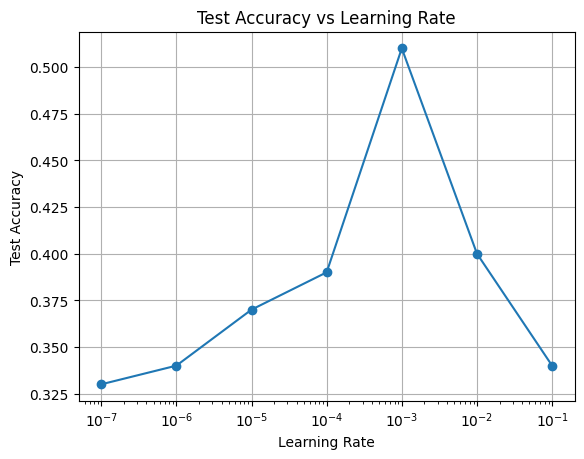

In [ ]:
plt.plot([10**(-i) for i in range(1, 7 + 1)], test_accs_vec, marker='o')
plt.xscale('log')  # Use log scale for better visualization if learning rates are on a wide scale
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

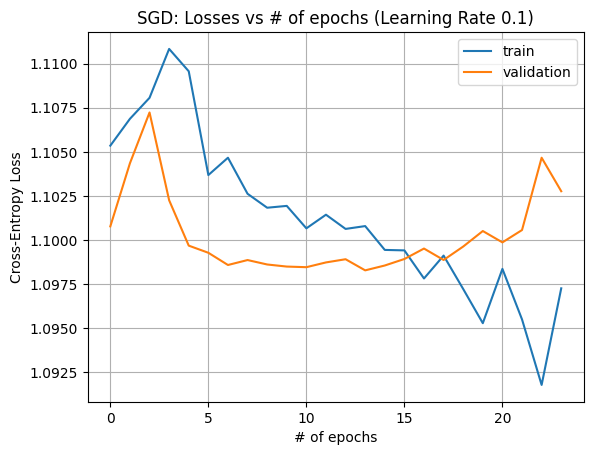

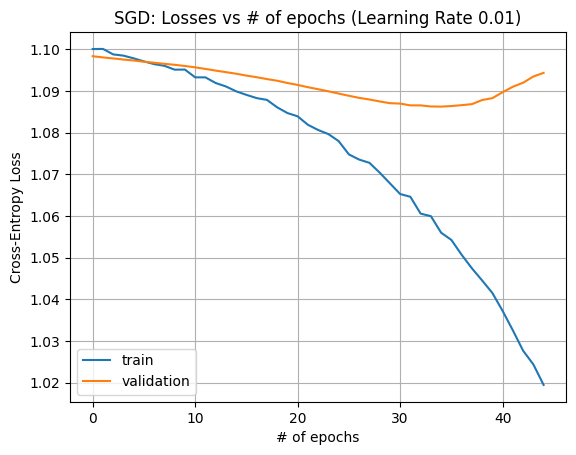

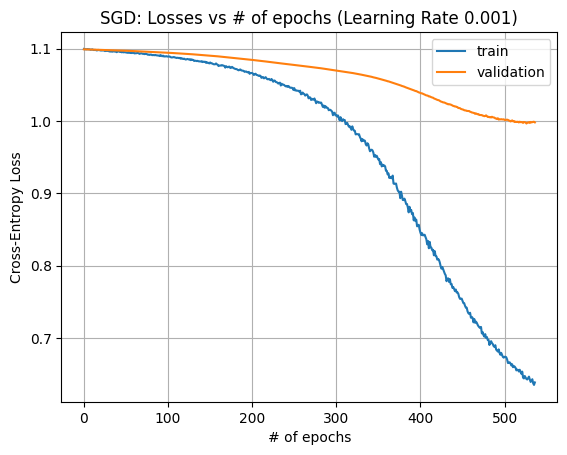

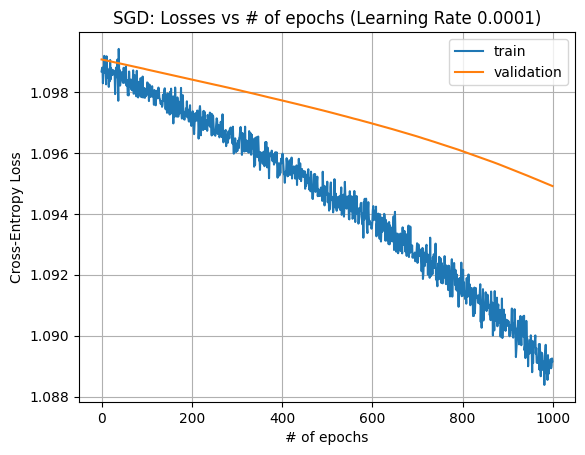

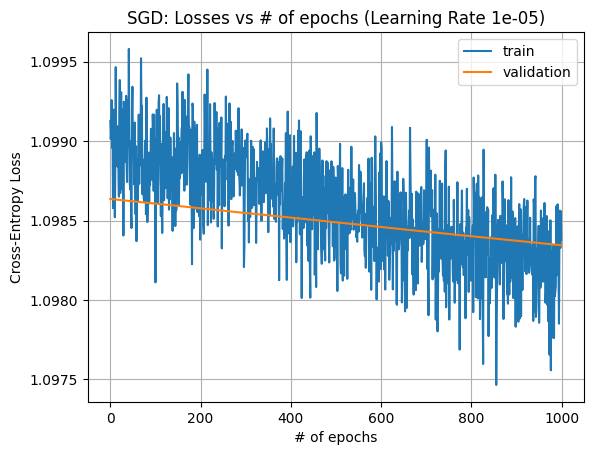

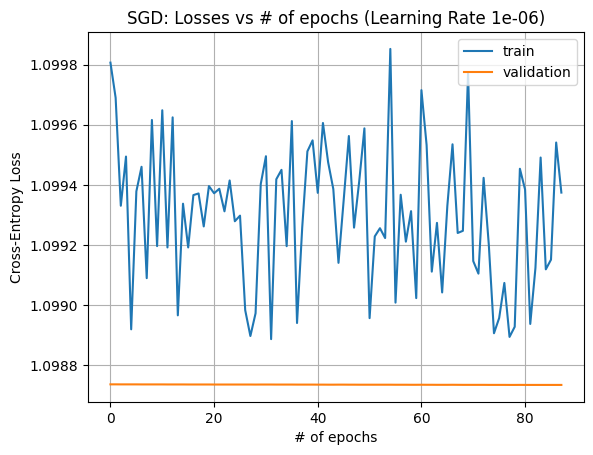

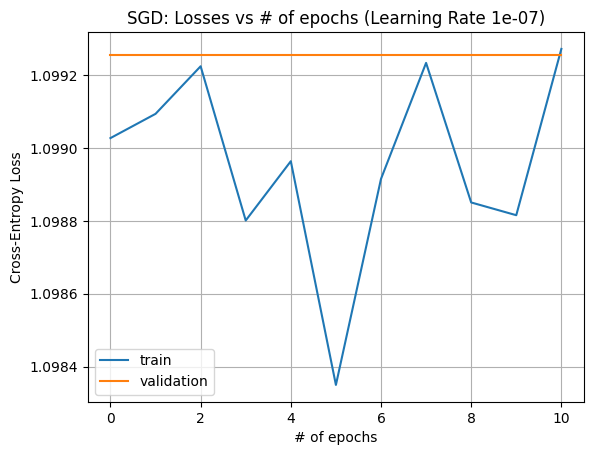

In [ ]:
for i in range(len(train_losses_vec)):
    plt.figure()  # Create a new figure for each index
    plt.xlabel('# of epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'SGD: Losses vs # of epochs (Learning Rate {10**(-(i+1))})')
    plt.plot(train_losses_vec[i], label="train")
    plt.plot(val_losses_vec[i], label="validation")
    plt.legend()
    plt.grid(which="both")
    plt.show()

In [ ]:
# Trying with the 6th layer

In [ ]:
with open('/content/drive/MyDrive/hidden_states_6.pkl', 'rb') as f:
    train_hidden_states = pickle.load(f)

In [ ]:
val_data, sent2_val_data = transformed_data(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.5.mlp', val_data, sent2_val_data)
test_data, sent2_test_data = transformed_data(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.5.mlp', test_data, sent2_test_data)

In [ ]:
print(len(train_hidden_states), len(val_hidden_states), len(test_hidden_states))
print(train_hidden_states[0].shape, val_hidden_states[0].shape, test_hidden_states[0].shape)

500 100 100
torch.Size([1, 10, 768]) torch.Size([1, 15, 768]) torch.Size([1, 8, 768])


In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([500, 26, 768]) torch.Size([100, 26, 768]) torch.Size([100, 26, 768])
torch.Size([500]) torch.Size([100]) torch.Size([100])


In [ ]:
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
inp_dims = 0
for batch in train_dataloader:
    data, labels = batch
    inp_dims = (data.shape[1] * data.shape[2])
    print(inp_dims)
    print(data.device, labels.device)
    print(data.dtype, labels.dtype)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    break

19968
cuda:0 cuda:0
torch.float32 torch.int64
Data shape: torch.Size([25, 26, 768])
Labels shape: torch.Size([25])


In [ ]:
optimal_sgd_learning_rate = 1e-3
optimal_adam_learning_rate = 1e-6

In [ ]:
# Trying SGD with best possible learning rate
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=optimal_sgd_learning_rate)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer)

Epoch 1 took 0.62s. Train loss: 1.0983 acc: 0.3540. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 2 took 0.68s. Train loss: 1.0984 acc: 0.3360. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 3 took 0.92s. Train loss: 1.0985 acc: 0.3380. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 4 took 0.68s. Train loss: 1.0983 acc: 0.3480. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 5 took 0.58s. Train loss: 1.0984 acc: 0.3340. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 6 took 0.32s. Train loss: 1.0983 acc: 0.3520. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 7 took 0.34s. Train loss: 1.0984 acc: 0.3380. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 8 took 0.38s. Train loss: 1.0985 acc: 0.3360. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 9 took 0.34s. Train loss: 1.0983 acc: 0.3420. Val loss: 1.0983 acc: 0.3400. Patience left: 10
Epoch 10 took 0.34s. Train loss: 1.0984 acc: 0.3360. Val loss: 1.0983 acc: 0.3400. Patience left: 10

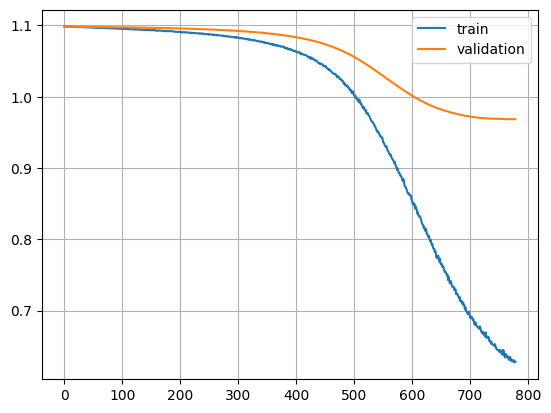

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.61

In [ ]:
# Trying 4th layer
train_data, sent2_train_data = transformed_data(train_lines)
train_hidden_states = get_all_hidden_states('transformer.h.3.mlp', train_data, sent2_train_data)
val_data, sent2_val_data = transformed_data(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.3.mlp', val_data, sent2_val_data)
test_data, sent2_test_data = transformed_data(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.3.mlp', test_data, sent2_test_data)

In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, patience=100)

Epoch 1 took 0.23s. Train loss: 1.0989 acc: 0.3280. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 2 took 0.30s. Train loss: 1.0989 acc: 0.3380. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 3 took 0.32s. Train loss: 1.0988 acc: 0.3340. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 4 took 0.33s. Train loss: 1.0988 acc: 0.3340. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 5 took 0.34s. Train loss: 1.0988 acc: 0.3420. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 6 took 0.35s. Train loss: 1.0991 acc: 0.3340. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 7 took 0.33s. Train loss: 1.0988 acc: 0.3340. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 8 took 0.38s. Train loss: 1.0987 acc: 0.3300. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 9 took 0.34s. Train loss: 1.0990 acc: 0.3360. Val loss: 1.0991 acc: 0.3300. Patience left: 100
Epoch 10 took 0.37s. Train loss: 1.0988 acc: 0.3360. Val loss: 1.0990 acc: 0.3300. Patience

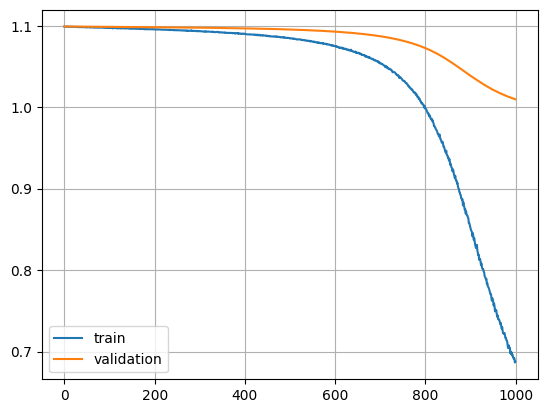

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.55999994

In [ ]:
# Trying 10th layer
train_data, sent2_train_data = transformed_data(train_lines)
train_hidden_states = get_all_hidden_states('transformer.h.9.mlp', train_data, sent2_train_data)
val_data, sent2_val_data = transformed_data(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.9.mlp', val_data, sent2_val_data)
test_data, sent2_test_data = transformed_data(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.9.mlp', test_data, sent2_test_data)

In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, patience=100)

Epoch 1 took 3.09s. Train loss: 1.0986 acc: 0.3340. Val loss: 1.0979 acc: 0.3600. Patience left: 100
Epoch 2 took 0.29s. Train loss: 1.0977 acc: 0.3240. Val loss: 1.0979 acc: 0.3500. Patience left: 100
Epoch 3 took 0.29s. Train loss: 1.0980 acc: 0.3440. Val loss: 1.0978 acc: 0.3500. Patience left: 100
Epoch 4 took 0.28s. Train loss: 1.0975 acc: 0.3500. Val loss: 1.0978 acc: 0.3600. Patience left: 100
Epoch 5 took 0.29s. Train loss: 1.0973 acc: 0.3700. Val loss: 1.0978 acc: 0.3600. Patience left: 100
Epoch 6 took 0.28s. Train loss: 1.0982 acc: 0.3280. Val loss: 1.0977 acc: 0.3600. Patience left: 100
Epoch 7 took 0.29s. Train loss: 1.0975 acc: 0.3780. Val loss: 1.0977 acc: 0.3600. Patience left: 100
Epoch 8 took 0.31s. Train loss: 1.0978 acc: 0.3500. Val loss: 1.0976 acc: 0.3500. Patience left: 100
Epoch 9 took 0.30s. Train loss: 1.0970 acc: 0.3580. Val loss: 1.0976 acc: 0.3500. Patience left: 100
Epoch 10 took 0.35s. Train loss: 1.0973 acc: 0.3420. Val loss: 1.0975 acc: 0.3600. Patience

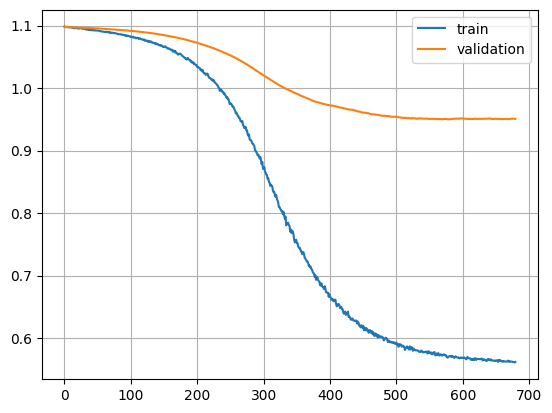

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.64

In [ ]:
# Trying a different prompt
prompt = " [CAUSED] "

In [ ]:
def transformed_data_v2(lines, prompt=" [CAUSED] "):
    training_data = []
    sent2_training_data = []
    for key in lines.keys():
        for sentence1, sentence2 in lines[key]:
            transformed_sent = sentence1 + prompt + sentence2
            training_data.append(transformed_sent)
            sent2_training_data.append(sentence2)
    return training_data, sent2_training_data

In [ ]:
train_data, sent2_train_data = transformed_data_v2(train_lines)
train_hidden_states = get_all_hidden_states('transformer.h.0.mlp', train_data, sent2_train_data)
val_data, sent2_val_data = transformed_data_v2(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.0.mlp', val_data, sent2_val_data)
test_data, sent2_test_data = transformed_data_v2(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.0.mlp', test_data, sent2_test_data)

In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, patience=100)

Epoch 1 took 2.81s. Train loss: 1.0991 acc: 0.3340. Val loss: 1.0990 acc: 0.3300. Patience left: 100
Epoch 2 took 0.29s. Train loss: 1.0990 acc: 0.3340. Val loss: 1.0990 acc: 0.3300. Patience left: 100
Epoch 3 took 0.28s. Train loss: 1.0988 acc: 0.3280. Val loss: 1.0989 acc: 0.3300. Patience left: 100
Epoch 4 took 0.28s. Train loss: 1.0992 acc: 0.3280. Val loss: 1.0989 acc: 0.3300. Patience left: 100
Epoch 5 took 0.30s. Train loss: 1.0990 acc: 0.3320. Val loss: 1.0988 acc: 0.3300. Patience left: 100
Epoch 6 took 0.29s. Train loss: 1.0983 acc: 0.3320. Val loss: 1.0988 acc: 0.3300. Patience left: 100
Epoch 7 took 0.28s. Train loss: 1.0984 acc: 0.3380. Val loss: 1.0988 acc: 0.3300. Patience left: 100
Epoch 8 took 0.29s. Train loss: 1.0986 acc: 0.3280. Val loss: 1.0987 acc: 0.3300. Patience left: 100
Epoch 9 took 0.31s. Train loss: 1.0985 acc: 0.3260. Val loss: 1.0987 acc: 0.3300. Patience left: 100
Epoch 10 took 0.42s. Train loss: 1.0983 acc: 0.3320. Val loss: 1.0987 acc: 0.3300. Patience

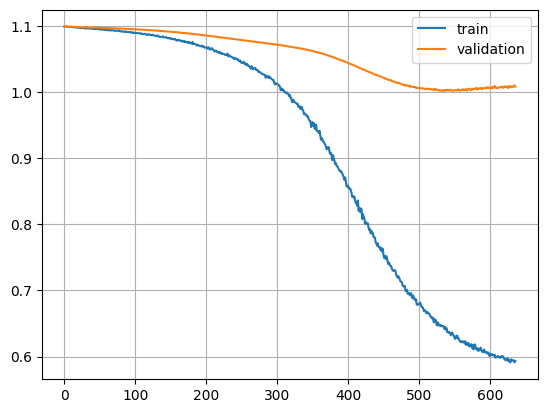

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.53999996

In [ ]:
def transformed_data_v3(lines, prompt=" [Has Different Meaning] "):
    training_data = []
    sent2_training_data = []
    for key in lines.keys():
        for sentence1, sentence2 in lines[key]:
            transformed_sent = sentence1 + prompt + sentence2
            training_data.append(transformed_sent)
            sent2_training_data.append(sentence2)
    return training_data, sent2_training_data

In [ ]:
train_data, sent2_train_data = transformed_data_v3(train_lines)
train_hidden_states = get_all_hidden_states('transformer.h.0.mlp', train_data, sent2_train_data)
val_data, sent2_val_data = transformed_data_v3(val_lines)
val_hidden_states = get_all_hidden_states('transformer.h.0.mlp', val_data, sent2_val_data)
test_data, sent2_test_data = transformed_data_v3(test_lines)
test_hidden_states = get_all_hidden_states('transformer.h.0.mlp', test_data, sent2_test_data)

In [ ]:
X_train, X_val, X_test = get_padded_sequence(train_hidden_states, val_hidden_states, test_hidden_states)
y_train, y_val, y_test = get_labels(train_lines, val_lines, test_lines)
train_dataset = Data_X_y(X_train, y_train)
val_dataset = Data_X_y(X_val, y_val)
test_dataset = Data_X_y(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=25, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, num_workers = 0)

In [ ]:
model = NeuralNetworkDropout(inp_dims=inp_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, patience=100)

Epoch 1 took 0.83s. Train loss: 1.0988 acc: 0.3640. Val loss: 1.0990 acc: 0.3300. Patience left: 100
Epoch 2 took 0.69s. Train loss: 1.0983 acc: 0.3440. Val loss: 1.0989 acc: 0.3300. Patience left: 100
Epoch 3 took 0.41s. Train loss: 1.0987 acc: 0.3740. Val loss: 1.0989 acc: 0.3100. Patience left: 100
Epoch 4 took 3.51s. Train loss: 1.0985 acc: 0.3480. Val loss: 1.0989 acc: 0.3200. Patience left: 100
Epoch 5 took 0.86s. Train loss: 1.0984 acc: 0.3300. Val loss: 1.0988 acc: 0.3200. Patience left: 100
Epoch 6 took 0.32s. Train loss: 1.0982 acc: 0.3540. Val loss: 1.0988 acc: 0.3200. Patience left: 100
Epoch 7 took 0.30s. Train loss: 1.0979 acc: 0.3540. Val loss: 1.0988 acc: 0.3300. Patience left: 100
Epoch 8 took 0.36s. Train loss: 1.0983 acc: 0.3540. Val loss: 1.0987 acc: 0.3300. Patience left: 100
Epoch 9 took 0.37s. Train loss: 1.0977 acc: 0.3760. Val loss: 1.0987 acc: 0.3300. Patience left: 100
Epoch 10 took 0.35s. Train loss: 1.0977 acc: 0.3680. Val loss: 1.0986 acc: 0.3300. Patience

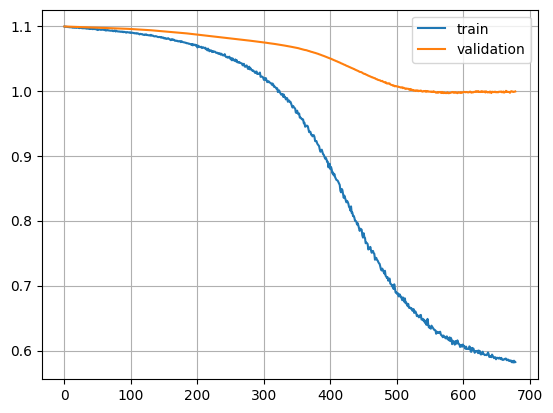

In [ ]:
plot_train_validation(train_losses, val_losses)

In [ ]:
test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

In [ ]:
test_acc

0.52